# Experiment IV: Character Bigram Only (Binary CLF for Probing Topic Control)

## I. PREPROCESSING

In [16]:
import os
import cPickle
import random
import string
import numpy as np
from string import punctuation as punc
from nltk import ngrams
from collections import defaultdict
from copy import deepcopy

In [3]:
data_dir = "/Users/jacobsw/Desktop/UNIV/SPRING_2017/CS388_NLP/PROJECT/DATA/19centurynovels/"

In [4]:
author2works = {'ab': ['agnes_grey.txt',
                      'the_tenant_of_wildfell_hall.txt'],
                'ja': ['emma.txt',
                      'mansfield_park.txt',
                      'sense_and_sensibility.txt'],
                'cb': ['jane_eyre.txt',
                      'the_professor.txt'],
                'jfc':['the_last_of_the_mohicans.txt',
                       'the_spy.txt',
                       'water_witch.txt'],
                'cd': ['bleak_house.txt',
                       'dombey_and_son.txt',
                       'great_expectations.txt'],
                'rwe':['the_conduct_of_life.txt',
                       'english_traits.txt'],
                'eb': ['wuthering_heights.txt'],
                'nh': ['the_house_of_the_seven_gables.txt'],
                'hm': ['moby_dick.txt',
                       'redburn.txt']}

author2name = {'ab': 'Anne Bronte', 'ja': 'Jane Austen', 'cb': 'Charlotte Bronte',
               'jfc': 'James Fenimore Cooper', 'cd': 'Charles Dickens',
               'rwe': 'Ralph Waldo Emerson', 'eb': 'Emily Bronte', 'nh': 'Nathaniel Hawthorne',
               'hm': 'Herman Melville'}

author2id = {'ab': 0, 'ja': 1, 'cb': 2, 'jfc': 3, 'cd': 4, 'rwe': 5, 'eb': 6, 'nh': 7, 'hm': 8}
num_cls = len(author2id)

seed = random.random()

### A. CHUNKING

In [5]:
charchunk_size = 1000 # for chunk_size = 200
# charchunk_size = 5000 # for chunk_size = 1000
# charchunk_size = 10000 # for chunk_size = 2000

def doc2words(path):
    words = []
    for line in open(path):
        line = line.strip().decode('ascii','ignore').encode("utf-8")
        if len(line)<1: continue
        for item in line.split():
            if item[-1] in punc:
                words.append(item[:-1])
                words.append(item[-1])
                continue
            words.append(item)
    return words

def chunkize(words, size=100):
    m = max(1, size)
    n = len(words)
    chunks = [words[i:i+m] for i in xrange(0, n, m)]
    return chunks if len(chunks[-1])==size else chunks[:-1]

def to_chars(chunk):
    chars = ''
    for i in range(len(chunk)-1):
        chars += chunk[i]+' ' if chunk[i+1] not in punc else chunk[i]
    return chars

def pad(chars):
    char_len = len(chars)
    if char_len<charchunk_size:
        return chars + ' '*(charchunk_size-char_len)
    return chars[:charchunk_size]    

def to_ngrams(chars, n=2):
    return list(ngrams(chars, n))

In [6]:
for author,works in author2works.iteritems():
    for work in works:
        print 'Work:', work, '| Length:', len(doc2words(data_dir + work))

Work: the_house_of_the_seven_gables.txt | Length: 124353
Work: agnes_grey.txt | Length: 81743
Work: the_tenant_of_wildfell_hall.txt | Length: 198367
Work: the_conduct_of_life.txt | Length: 81855
Work: english_traits.txt | Length: 78499
Work: moby_dick.txt | Length: 250017
Work: redburn.txt | Length: 140229
Work: the_last_of_the_mohicans.txt | Length: 172324
Work: the_spy.txt | Length: 52020
Work: water_witch.txt | Length: 183212
Work: jane_eyre.txt | Length: 220643
Work: the_professor.txt | Length: 105499
Work: wuthering_heights.txt | Length: 139893
Work: emma.txt | Length: 184695
Work: mansfield_park.txt | Length: 186312
Work: sense_and_sensibility.txt | Length: 138897
Work: bleak_house.txt | Length: 412730
Work: dombey_and_son.txt | Length: 418487
Work: great_expectations.txt | Length: 216403


### B. FEATURIZE TO RAW STRINGS

In [8]:
def author_work_featurize(author, work, size):
    assert author in author2works
    bichars_data = []
    words = doc2words(data_dir + work)
    chunks = chunkize(words, size)
    for chunk in chunks:            
        bichars_data.append((to_ngrams(pad(to_chars(chunk)), 2), author))   
    return np.array(bichars_data)

In [21]:
jfc_mohicans = author_work_featurize('jfc', 'the_last_of_the_mohicans.txt', 200)     # x_a, Length: 172324
jfc_witch    = author_work_featurize('jfc', 'water_witch.txt', 200)                  # x_b, Length: 183212
ja_mansfield = author_work_featurize('ja', 'mansfield_park.txt', 200)                # "noise"

In [24]:
print jfc_mohicans.shape, jfc_witch.shape, ja_mansfield.shape

(861, 2) (916, 2) (931, 2)


In [28]:
train = np.concatenate((jfc_mohicans,ja_mansfield))
test  = np.concatenate((jfc_witch,ja_mansfield))
print train.shape, test.shape

(1792, 2) (1847, 2)


### C. FEATURIZE TO INDICES

In [33]:
vocab_size = 0

# Visualization
index2bichar = {}

num_cls = 2
testauthor2id = {'jfc':0, 'ja':1}

def vectorize(author):
    vec = np.zeros(num_cls)
    vec[testauthor2id[author]] = 1
    return vec

def get_id(item, dic, unk=False):
    if unk: return len(dic)
    if item not in dic:
        new_index = len(dic)
        dic[item] = new_index
        index2bichar[new_index] = item
    return dic[item]

def to_onehot(train, test):
    
    X_train, X_test, Y_train, Y_test = [], [], [], []
    
    bichar_dic = {}
    for bichars,a in train:
        bichar_ids = [get_id(bichar,bichar_dic) for bichar in bichars]
        X_train.append(bichar_ids)
        Y_train.append(vectorize(a))
    global vocab_size
    vocab_size = len(bichar_dic) + 1
    print "vocab size", vocab_size
    
    for bichars,a in test:
        bichar_ids = [get_id(bichar,bichar_dic) if bichar in bichar_dic else get_id(bichar,bichar_dic,unk=True) 
                      for bichar in bichars]
        X_test.append(bichar_ids)
        Y_test.append(vectorize(a))
    global index2bichar
    index2bichar[len(bichar_dic)] = '<unk>'
        
    return np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

In [34]:
%%time
X_train, X_test, Y_train, Y_test = to_onehot(train, test)

vocab size 1504
CPU times: user 1.62 s, sys: 43.2 ms, total: 1.66 s
Wall time: 1.65 s


In [35]:
class DataIterator:
    
    def __init__(self, X, Y):
        self.X = deepcopy(X)
        self.Y = deepcopy(Y)
        self.size = len(X)
        self.indices = np.arange(self.size)
        self.epoch = 0
        self.cursor = 0
        self.shuffle()
    
    def shuffle(self):
        random.shuffle(self.indices)
        self.X = self.X[self.indices]
        self.Y = self.Y[self.indices]
        self.cursor = 0
    
    def next_batch(self, n):
        if self.cursor+n > self.size:
            self.epoch += 1
            self.shuffle()
        X_batch, Y_batch = self.X[self.cursor:self.cursor+n], self.Y[self.cursor:self.cursor+n]
        self.cursor += n
        return X_batch, Y_batch


## II. CONV NETS

In [36]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

In [37]:
def reset_graph():
    # Clean existing graph before start.
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [38]:
####################################################################################################
################################ SHAPE/CHANNEL ARGUMENTS ###########################################
####################################################################################################
# a = tf.placeholder(tf.float32, shape=[1,5,10,1]) # shape=[batch,height/#row,width/#col,#channels]
# f = tf.constant(1.0, shape=[5,3,1,4]) # shape=[height/#row,width/#col,#channels,#ft_maps]
# a_conv = tf.nn.conv2d(a, f, strides=[1,1,1,1], padding='VALID') # strides: step size along dimensions.
# a_maxpool = tf.nn.max_pool(a_conv, ksize=[1,1,8,1], strides=[1,1,8,1], padding='VALID')

# # SHAPES 
# #   Tensor("Placeholder_3:0", shape=(1, 5, 10, 1), dtype=float32)
# #   Tensor("Const_2:0", shape=(5, 3, 1, 10), dtype=float32)
# #   Tensor("Conv2D_2:0", shape=(1, 1, 8, 10), dtype=float32)
# #   Tensor("MaxPool_1:0", shape=(1, 1, 1, 4), dtype=float32)
# # CHANNELS
# #   Channels are summed up: 
# #   http://stackoverflow.com/questions/27728531/convolutional-neural-networks-multiple-channels
####################################################################################################

In [39]:
reset_graph()

evaluate_train = False

x_size = charchunk_size - 1 # bigrams size = unigrams size - 1
emb_size = 50

reg = True
l2_reg_lambda = 0.01

X = tf.placeholder(tf.float32, shape=[None, x_size], name='bichars')
y = tf.placeholder(tf.float32, shape=[None, num_cls], name='labels')

# def get_embedding(X_):
#     emb = tf.Variable(tf.random_uniform([vocab_size, emb_size], -1.0, 1.0), name='embeddings')
#     return tf.nn.embedding_lookup(emb, tf.cast(X_, tf.int32))
# X_emb = get_embedding(X)

emb = tf.Variable(tf.random_uniform([vocab_size, emb_size], -1.0, 1.0), name='embeddings')
X_emb = tf.nn.embedding_lookup(emb, tf.cast(X, tf.int32))

X_input = tf.expand_dims(X_emb, -1)

flt1_height = 3 # 3 item window
flt2_height = 4 # 4 item window
flt3_height = 5 # 5 item window
flt_width  = emb_size
num_chnls  = 1
num_ftmaps = 30

def initialize_variable(shape, vtype, name):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer()) if vtype=='W' else \
           tf.Variable(tf.constant(0.1, shape=shape), name)
def init_wgts():
    W1 = initialize_variable([flt1_height,flt_width,num_chnls,num_ftmaps], vtype='W', name='W1')
    W2 = initialize_variable([flt2_height,flt_width,num_chnls,num_ftmaps], vtype='W', name='W2')
    W3 = initialize_variable([flt3_height,flt_width,num_chnls,num_ftmaps], vtype='W', name='W3')
    return W1, W2, W3
def init_bias():
    b1 = initialize_variable([num_ftmaps], vtype='b', name='b1') 
    b2 = initialize_variable([num_ftmaps], vtype='b', name='b2') 
    b3 = initialize_variable([num_ftmaps], vtype='b', name='b3') 
    return b1, b2, b3 

W1_conv, W2_conv, W3_conv = init_wgts()
b1_conv, b2_conv, b3_conv = init_bias()

keep_prob = tf.placeholder(tf.float32)
def conv2d(X_input_, W_):
    return tf.nn.conv2d(X_input_, W_, 
                        strides=[1,1,1,1], 
                        padding='VALID')
def max_pool(h, flt_height): 
    return tf.nn.max_pool(h, 
                          ksize=[1,x_size-flt_height+1,1,1], 
                          strides=[1,1,1,1], 
                          padding='VALID') 
        # NB: [batch,height/#row,width/#col,#channels]
def pool_vec(X_input_, W_, b_, flt_height):
    h_conv = tf.nn.relu(tf.nn.bias_add(conv2d(X_input_, W_), b_))
    h_pool = max_pool(h_conv, flt_height)
    return h_pool

h1_vec = pool_vec(X_input, W1_conv, b1_conv, flt1_height)
h2_vec = pool_vec(X_input, W2_conv, b2_conv, flt2_height)
h3_vec = pool_vec(X_input, W3_conv, b3_conv, flt3_height)

X_vec = tf.nn.dropout(tf.reshape(tf.concat([h1_vec,h2_vec,h3_vec], 3), [-1, num_ftmaps*3]), keep_prob)

W = tf.get_variable("W",shape=[num_ftmaps*3, num_cls],initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.constant(0.1, shape=[num_cls],name="b"))
l2_loss = tf.constant(0.0)
l2_loss += tf.nn.l2_loss(W)
l2_loss += tf.nn.l2_loss(b)

logits  = tf.nn.xw_plus_b(X_vec, W, b, name="logits")
softmax = tf.nn.softmax(logits)
y_pred  = tf.argmax(softmax, 1, name="predictions")
# y_pred = tf.argmax(logits, 1, name="predictions")
y_true = tf.argmax(y, 1)

if reg:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)) + l2_reg_lambda * l2_loss
else:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

correct = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(correct, 'float'), name="accuracy")

train = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Visualization (Li et al., 2016; Shrestha et al., 2017)
salience_grads = tf.gradients(loss, X_emb)[0]

batch_size = 32
num_epochs = 20

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    gen = DataIterator(X_train, Y_train)
    num_iters = 0
    train_losses, train_accs = [], []
    while gen.epoch<num_epochs:
        num_iters += 1
        X_batch, Y_batch = gen.next_batch(batch_size)
        _, train_loss, train_acc = sess.run([train, loss, accuracy], 
                                             feed_dict={X:X_batch, 
                                                        y:Y_batch, 
                                                        keep_prob:0.75})
        if num_iters%10==0:
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            print "Stats:", "epoch =", gen.epoch, "| iters =", num_iters, "| loss:", train_loss, "| acc:", train_acc
            
    if evaluate_train:
        train_loss, train_acc, train_true, train_pred = sess.run([loss, accuracy, y_true, y_pred], 
                                                                  feed_dict={X:X_train, 
                                                                             y:Y_train, 
                                                                             keep_prob:1.0})
        prec = precision_score(train_true, train_pred)
        rec = recall_score(train_true, train_pred)
        f1 = f1_score(train_true, train_pred)    
        print
        print "Train Stats:"
        print "    loss =", train_loss, "| acc =", train_acc
        print "    prec =", prec, "| rec =", rec, "| f1 =", f1    
    grads, test_loss, test_acc, test_true, test_pred = sess.run([salience_grads, loss, accuracy, y_true, y_pred], 
                                                                 feed_dict={X:X_test, 
                                                                            y:Y_test, 
                                                                            keep_prob:1.0})
    
    prec = precision_score(test_true, test_pred, average='micro')
    rec = recall_score(test_true, test_pred, average='micro')
    f1 = f1_score(test_true, test_pred, average='micro')    
    print
    print "Test Stats:"
    print "    loss =", test_loss, "| acc:", test_acc
    print "    prec =", prec, "| rec =", rec, "| f1 =", f1  
    

Stats: epoch = 0 | iters = 10 | loss: 0.691863 | acc: 0.5625
Stats: epoch = 0 | iters = 20 | loss: 0.73667 | acc: 0.53125
Stats: epoch = 0 | iters = 30 | loss: 0.74095 | acc: 0.5
Stats: epoch = 0 | iters = 40 | loss: 0.61619 | acc: 0.6875
Stats: epoch = 0 | iters = 50 | loss: 0.775735 | acc: 0.40625
Stats: epoch = 1 | iters = 60 | loss: 0.744272 | acc: 0.59375
Stats: epoch = 1 | iters = 70 | loss: 0.697947 | acc: 0.53125
Stats: epoch = 1 | iters = 80 | loss: 0.737626 | acc: 0.625
Stats: epoch = 1 | iters = 90 | loss: 0.603204 | acc: 0.71875
Stats: epoch = 1 | iters = 100 | loss: 0.643531 | acc: 0.65625
Stats: epoch = 1 | iters = 110 | loss: 0.534695 | acc: 0.78125
Stats: epoch = 2 | iters = 120 | loss: 0.537699 | acc: 0.6875
Stats: epoch = 2 | iters = 130 | loss: 0.553069 | acc: 0.75
Stats: epoch = 2 | iters = 140 | loss: 0.507285 | acc: 0.78125
Stats: epoch = 2 | iters = 150 | loss: 0.544895 | acc: 0.71875
Stats: epoch = 2 | iters = 160 | loss: 0.581262 | acc: 0.71875
Stats: epoch = 3

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def graph_loss_acc(train_losses, train_accs):
    fig, ax1 = plt.subplots(figsize=(10,8))
    ax2 = ax1.twinx()
    ln1 = ax1.plot(train_losses, color='r', label='loss')
    ln2 = ax2.plot(train_accs, color='g', label='acc')
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.set_xlabel('# iterations')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax2.legend(lns, labs, loc='upper left') # ax1.legend causes legend to be crossed by grid lines.
    plt.title('Loss & Accuracy')
    plt.show()

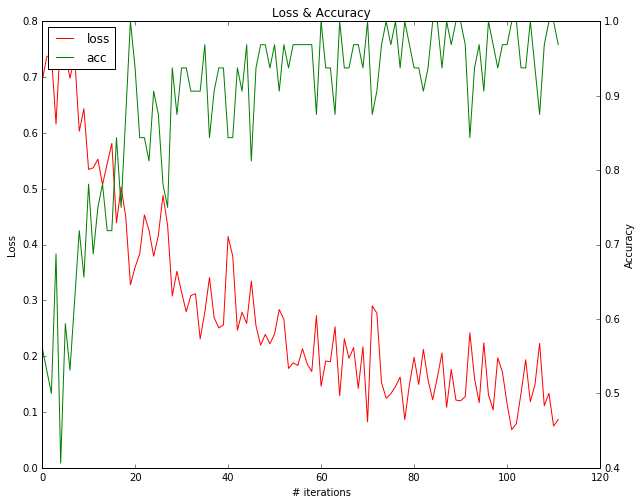

In [42]:
graph_loss_acc(train_losses, train_accs)

### HEATMAP

In [43]:
print grads.shape, X_test.shape

(1847, 999, 50) (1847, 999)


In [44]:
def to_charticks(x):
    return [a+b for a,b in map(lambda idx:index2bichar[idx], x)]

def heatmap(idx, start, end, step=50, cmap_type='hot_r'):
    t = abs(grads[idx]).max(axis=1)
    indices = range(start, end+1, step)
    num_bars = len(indices)-1
    f, ax = plt.subplots(num_bars,figsize=(20,20)) # figsize=(width,height)
    f.tight_layout()
    for i in range(num_bars):
        ax[i].imshow(t[indices[i]:indices[i+1]][np.newaxis,:], cmap=cmap_type, interpolation='nearest')
        ax[i].set_xticks(np.arange(step))
        ax[i].set_xticklabels(to_charticks(X_test[idx])[indices[i]:indices[i+1]])

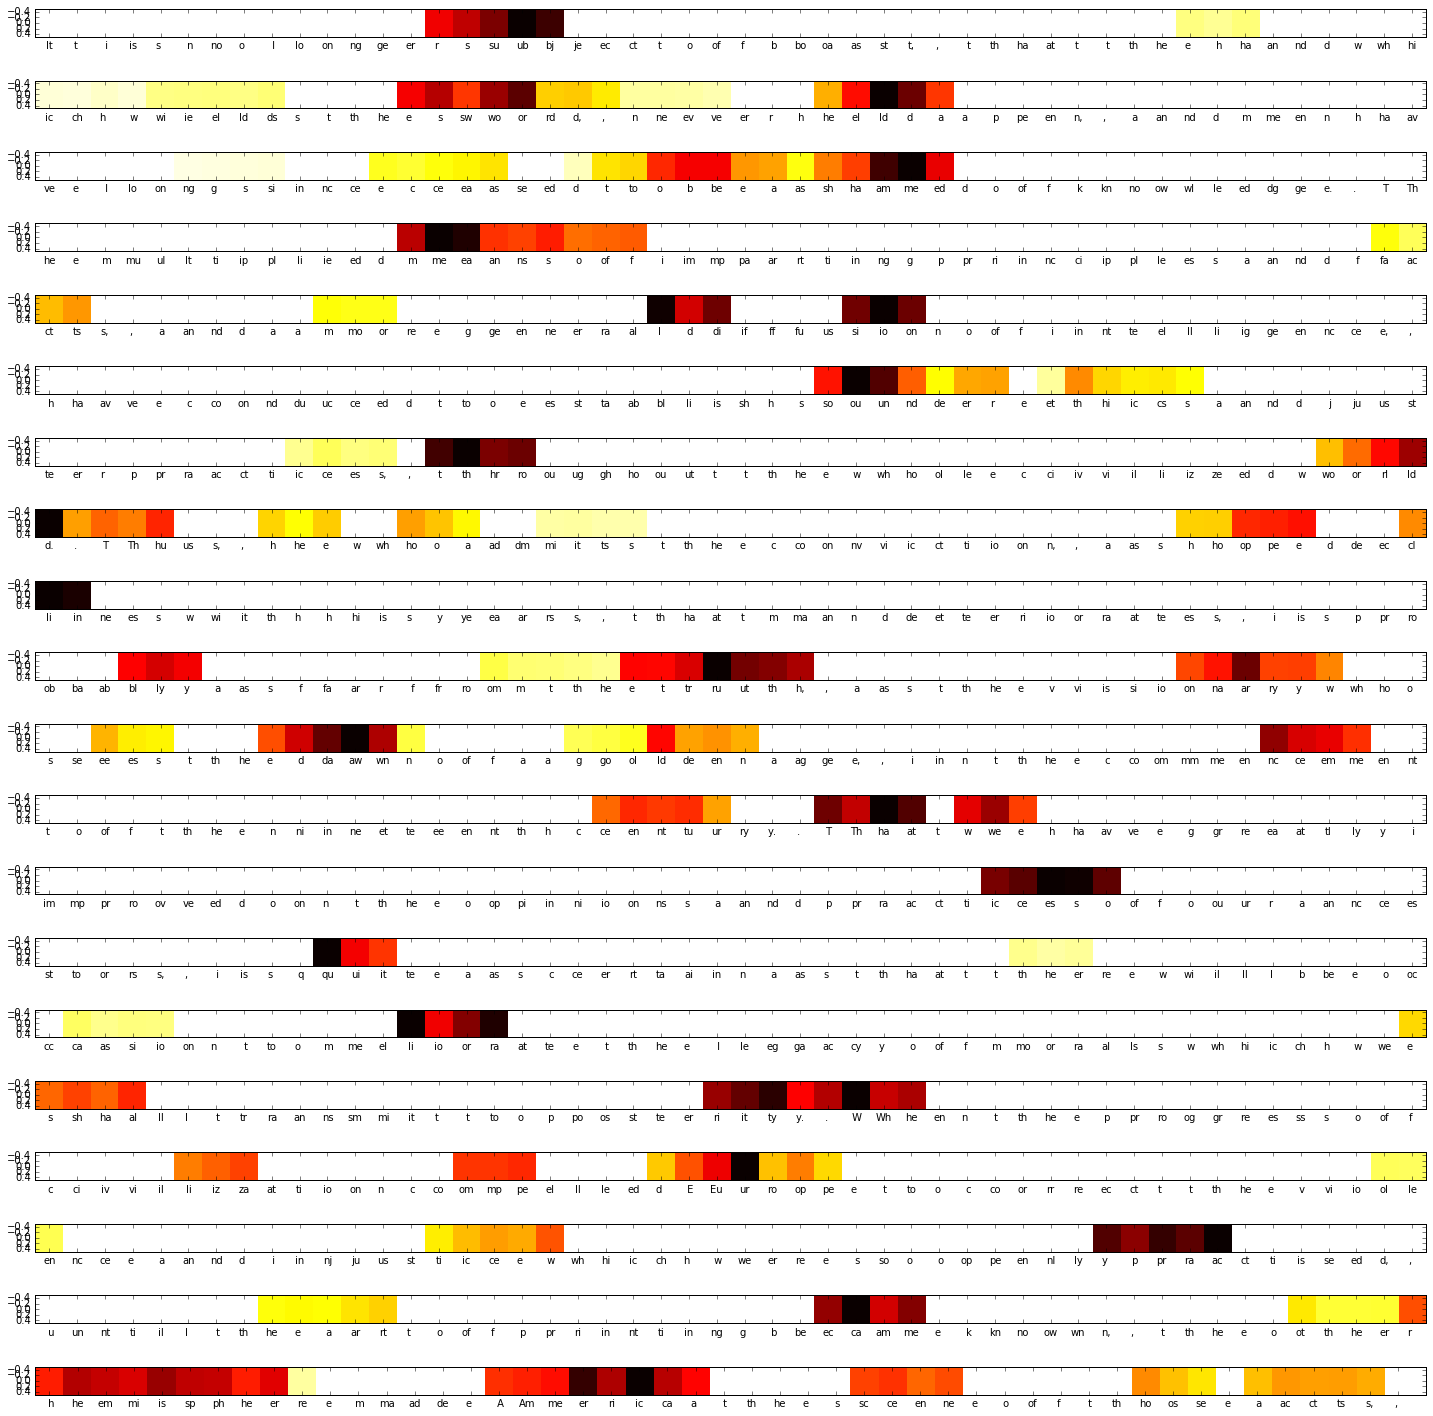

In [45]:
heatmap(1,0,1000)

In [ ]:
# TODO: PICK A CHERRY, PICK A LEMON